# Machine Learning Supervisado

En esta sesión veremos como implementar los distintos algoritmos de aprendizaje supervisado que hemos presentado en el fastbook. Para ello, usaremos un par de datasets de kaggle y la librería scikit-learn.

#### Indice 

- Regresión Lineal 
	- 	Problema 

	- 	Análisis y tratamiento de los datos 

	- Modelado (RL y Lasso) 

	- Selección de características 

- Clasificación 

	- Definición del problema. 

	- Arboles de Decisión. 

	- Random Forest 

	- Support Vector Machines 

	- kNN 

- Conclusiones 
        

# Regresión

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import linear_model

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
rn_state = 42 # random state for reproducibility

### Presentacion del problema

Cargamos un dataset de kaggle ([perth-house-pries](https://www.kaggle.com/datasets/syuzai/perth-house-prices))

- Información sobre las casas y su precio
- Objetivo: Predecir el precio de las casas en Boston.

### Análisis de Datos

In [221]:
df_houses = pd.read_csv('Housing.csv')
df_houses.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [222]:
print("Tamaño del dataset: ",df_houses.shape)

Tamaño del dataset:  (545, 13)


Ahora comprobamos si hay algún campo con valores nan, y planteamos cómo limpiar estos valores

In [223]:
df_houses.isnull().sum()*100/df_houses.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

Análisis de los datos

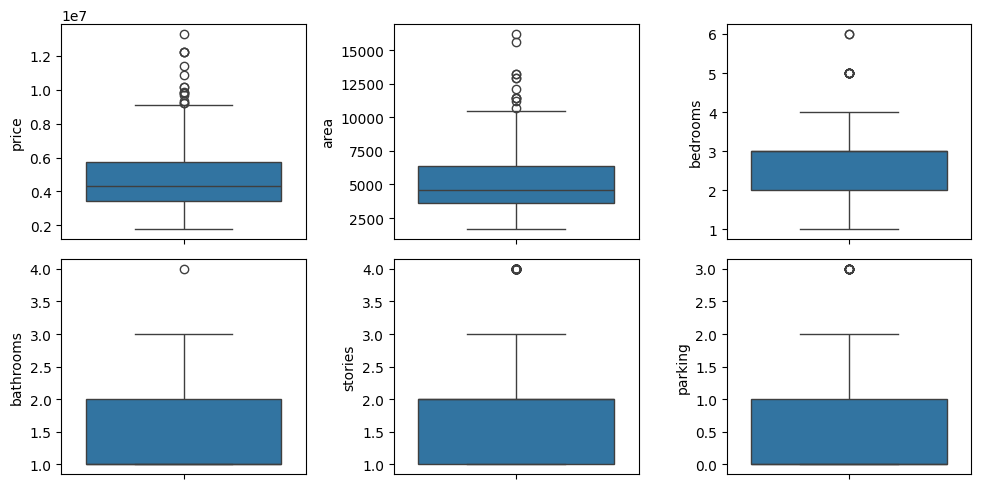

In [224]:
# Outlier Analysis
fig, axs = plt.subplots(2,3, figsize = (10,5))
plt1 = sns.boxplot(df_houses['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_houses['area'], ax = axs[0,1])
plt3 = sns.boxplot(df_houses['bedrooms'], ax = axs[0,2])
plt1 = sns.boxplot(df_houses['bathrooms'], ax = axs[1,0])
plt2 = sns.boxplot(df_houses['stories'], ax = axs[1,1])
plt3 = sns.boxplot(df_houses['parking'], ax = axs[1,2])

plt.tight_layout()

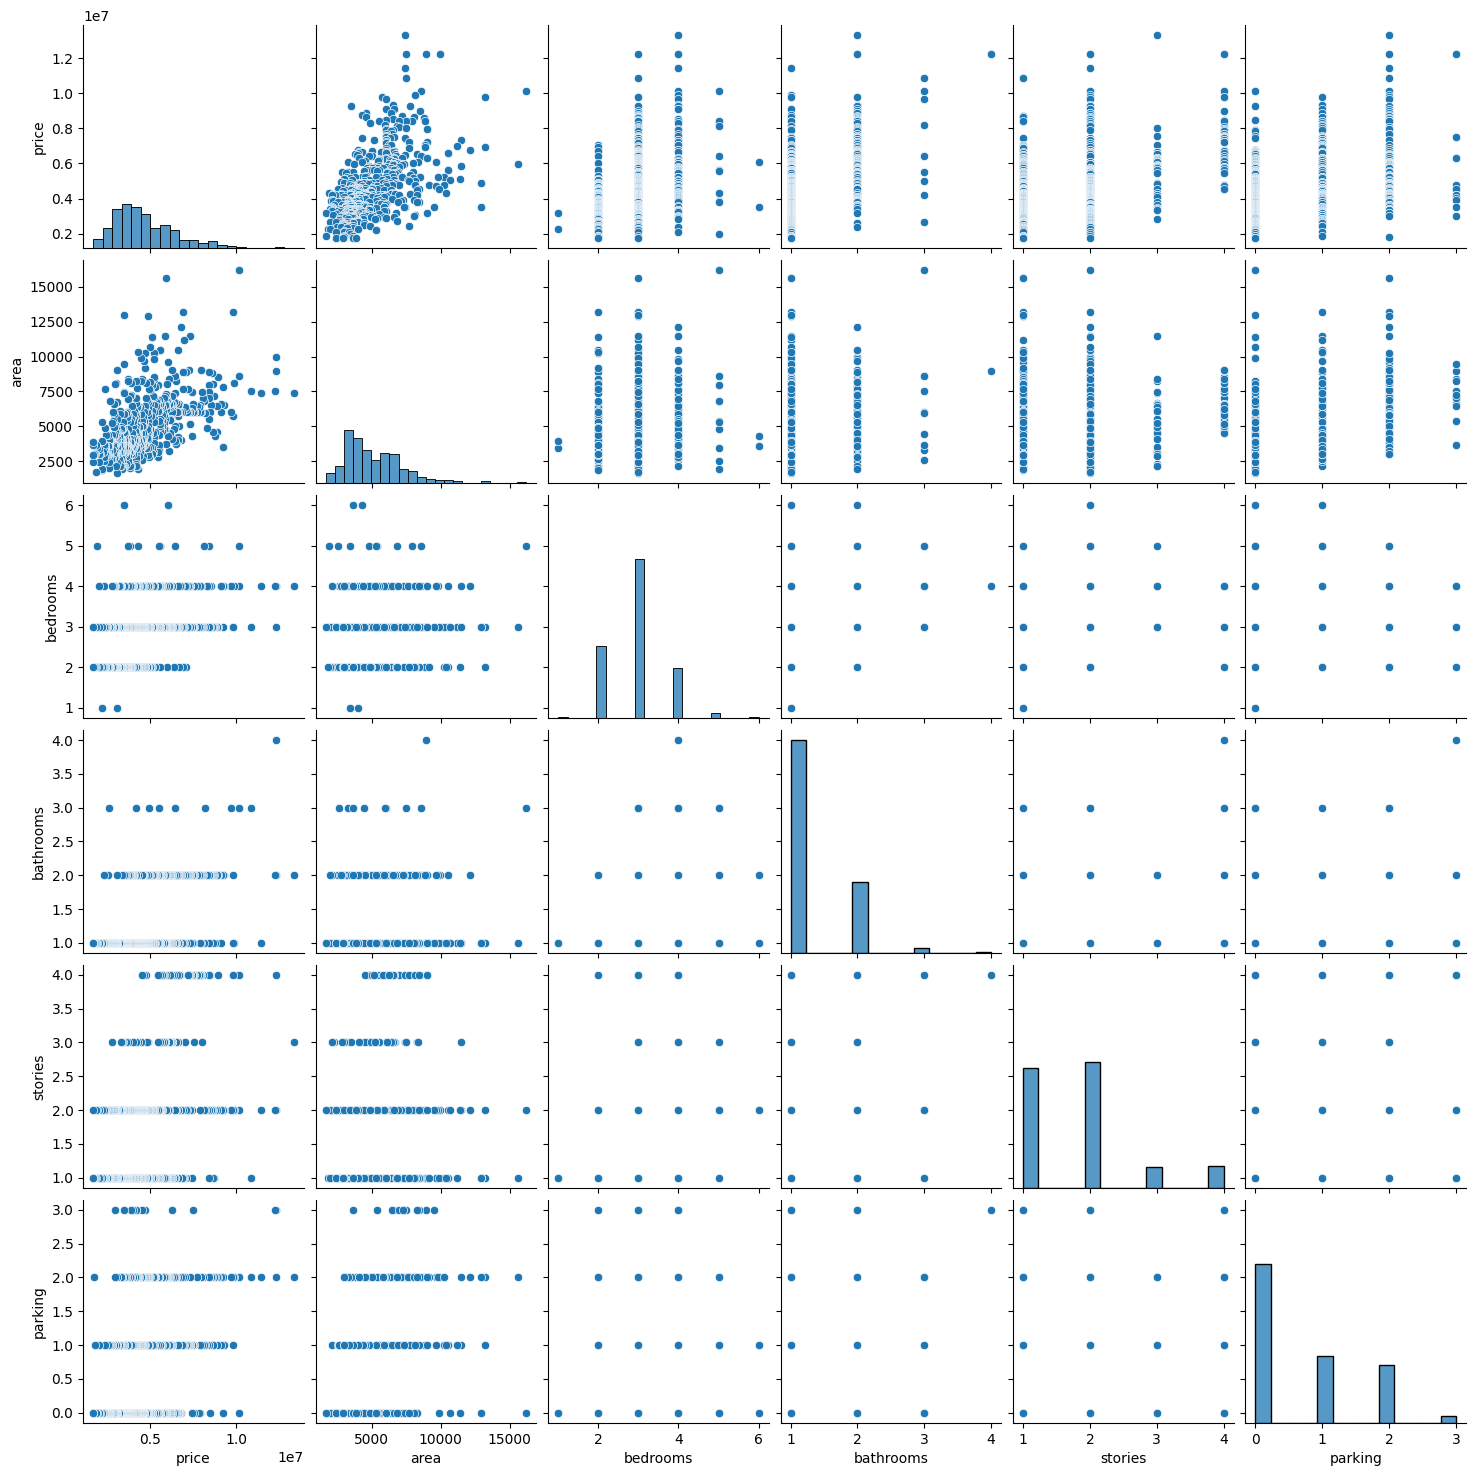

In [225]:
sns.pairplot(df_houses)
plt.show()

Convertimos en variables dummy las variables categóricas

In [226]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# Applying the function to the housing list
df_houses[varlist] = df_houses[varlist].apply(binary_map)

In [227]:
df_houses.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [228]:
status = pd.get_dummies(df_houses['furnishingstatus'], dtype=int)
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [229]:
df_houses = pd.concat([df_houses, status], axis = 1)

df_houses.drop(['furnishingstatus'], axis = 1, inplace = True)
# Now let's see the head of our dataframe.

df_houses.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


Con los datos limpios, podemos dividirlos en train y test (Validación).

#### Preparación de los subconjuntos de **Train** y **Test**

In [230]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_houses[num_vars] = scaler.fit_transform(df_houses[num_vars])

df_houses.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,1.000000,0.396564,0.6,0.333333,0.666667,1,0,0,0,1,0.666667,1,1,0,0
1,0.909091,0.502405,0.6,1.000000,1.000000,1,0,0,0,1,1.000000,0,1,0,0
2,0.909091,0.571134,0.4,0.333333,0.333333,1,0,1,0,0,0.666667,1,0,1,0
3,0.906061,0.402062,0.6,0.333333,0.333333,1,0,1,0,1,1.000000,1,1,0,0
4,0.836364,0.396564,0.6,0.000000,0.333333,1,1,1,0,1,0.666667,0,1,0,0


In [231]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_houses.drop(columns=['price']),
    df_houses['price'],
    test_size=0.2,
    random_state=rn_state)

## Regresión lineal

Con nuestros datos limpios, podemos empezar a modelar.

Para utilizar modelos clásicos, usaremos la librería scikit-learn. Esta librería tiene una interfaz muy sencilla, y es muy fácil de usar.
https://scikit-learn.org/stable/

Es comúnmente usada y veremos que el uso de sus modelos es bastante estandarizado.
Por lo general necesitaremos:
- Cargar el modelo
- Hacer fit() con los datos de entrenamiento
- Comprobar el score con los datos de test
- Utilizarlo con predict()

In [232]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [233]:
from sklearn.metrics import r2_score 

y_pred = lm.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print('Mean absolute error (MAE): %.2f' % mean_absolute_error(y_test, y_pred))
print('Root Mean squared error (RMSE): %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.6632635561791168
Mean absolute error (MAE): 0.08
Root Mean squared error (RMSE): 0.11


Text(0, 0.5, 'y_pred')

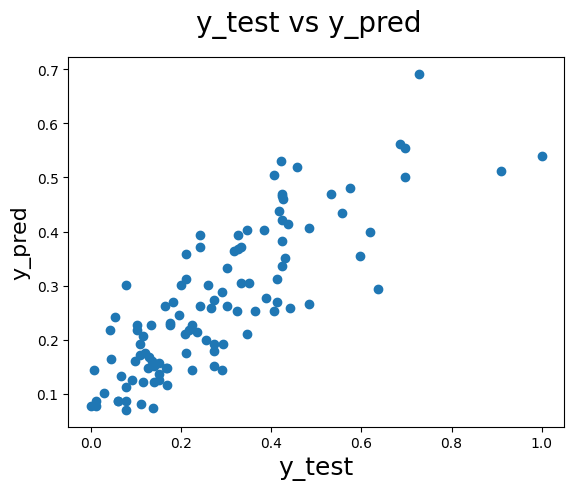

In [234]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16) 

Text(0.5, 0, 'Errors')

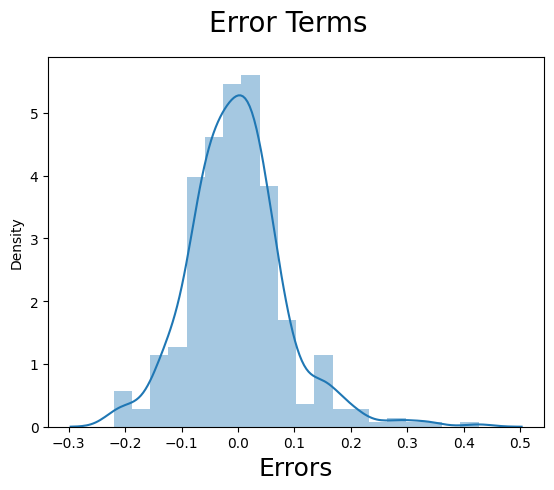

In [235]:
y_train_price = lm.predict(X_train)
res = (y_train_price - y_train)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   

#### Recursive Feature Elimination



In [236]:
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', False, 7),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', False, 6),
 ('guestroom', False, 8),
 ('basement', False, 2),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('furnished', False, 4),
 ('semi-furnished', False, 5),
 ('unfurnished', False, 3)]

Mantenemos las 6 características que más aportan

In [237]:
col = X_train.columns[rfe.support_]
print("Selected Features: ", X_train.columns[rfe.support_].to_list())


Selected Features:  ['area', 'bathrooms', 'stories', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']


Y las 6 caracterísitcas que eliminamos

In [238]:
not_cols = X_train.columns[~rfe.support_]
print("Removed Features: ", X_train.columns[~rfe.support_].to_list())

Removed Features:  ['bedrooms', 'mainroad', 'guestroom', 'basement', 'furnished', 'semi-furnished', 'unfurnished']


In [239]:
lm = LinearRegression()
lm.fit(X_train[col], y_train)

y_pred = lm.predict(X_test[col])

print("R2 Score:", r2_score(y_test, y_pred))
print('Mean absolute error (MAE): %.2f' % mean_absolute_error(y_test, y_pred))
print('Root Mean squared error (RMSE): %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.6224145510430448
Mean absolute error (MAE): 0.09
Root Mean squared error (RMSE): 0.12


### Modelo LASSO

En regresión lineal nos hemos parado más en cómo evaluar un modelo de regresión, que en el modelo en sí. Ahora vamos a ver un modelo de regresión lineal regularizado, LASSO.

Vamos a ver que los pasos son similares sino idénticos a los de regresión lineal.

Cargamos el modelo y lo entrenamos

In [ ]:
lasso = linear_model.Lasso()
lasso = lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print('Mean absolute error (MAE): %.2f' % mean_absolute_error(y_test, y_pred))
print('Root Mean squared error (RMSE): %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.6529242642007146
Mean absolute error (MAE): 0.08
Root Mean squared error (RMSE): 0.11


Podemos calcular sus métricas de la misma forma

Con esto, podemos ver cómo evaluar y comparar modelos de regresión. Podemos expandir esta idea a cualquier modelo de regresión e incluso podemos usar sus librerías para modificarlos.

# Clasificación

Para clasificación empezaremos con un dataset sencillo, [iris](https://www.kaggle.com/datasets/uciml/iris)

Un dataset dedicado a la clasificación de flores de iris. Según características como el tamaño de los pétalos, el tamaño de los sépalos, etc.

In [190]:
df_iris = pd.read_csv('IRIS.csv')
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


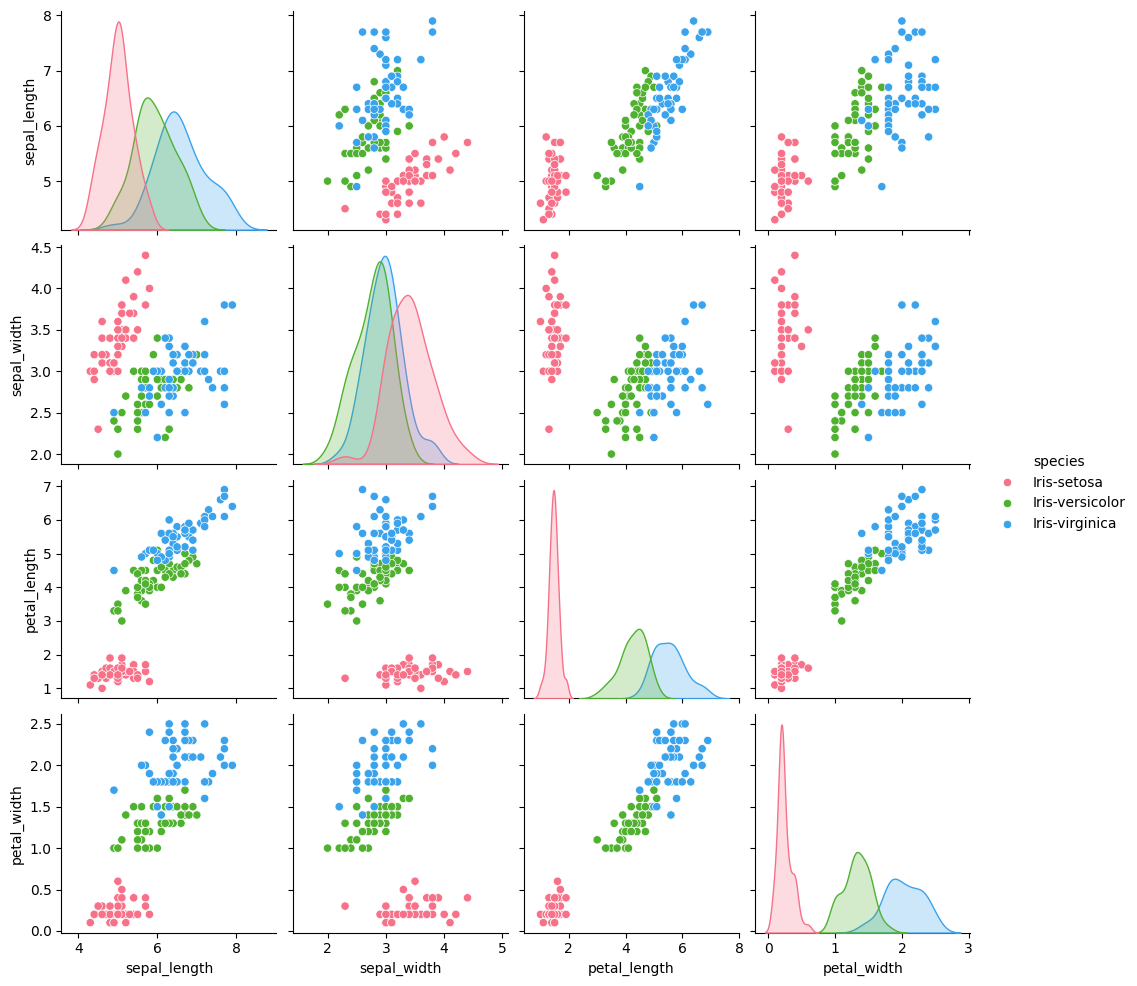

In [191]:
sns.pairplot(df_iris, hue='species', palette='husl')

plt.show()

Comprobamos si las clases están correctamente balanceadas

In [192]:
df_iris['species'].value_counts(dropna=False)

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Este dataset ya está limpio, por lo que tan sólo necesitamos dividirlo en train y test.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(
    df_iris.drop(columns=['species']), 
    df_iris['species'], 
    test_size=0.2, 
    random_state=rn_state)

## Árboles de decisión

Empezaremos estudiando los árboles de decisión, que son un modelo muy sencillo de entender y que nos permitirá ver cómo se comportan los modelos de clasificación.
Una vez más usaremos la librería de scikit-learn. Y veremos que el uso de los modelos es igual.

In [194]:
from sklearn import tree 

DT = tree.DecisionTreeClassifier(random_state=rn_state)
DT.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

El score en este caso será el accuracy del modelo, que es una de las métricas que habíamos visto de interés

In [195]:
print(classification_report(y_train, DT.predict(X_train)))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       1.00      1.00      1.00        41
 Iris-virginica       1.00      1.00      1.00        39

       accuracy                           1.00       120
      macro avg       1.00      1.00      1.00       120
   weighted avg       1.00      1.00      1.00       120



Tenemos un accuracy perfecto tanto en entrenamiento como en test, por lo que hasta donde sabemos nuestro modelo no comete fallos (En realidad podemos determinar que no tenemos datos suficientes como para saber en qué puntos nuestro modelo falla)

Una ventaja de los árboles de decisión es que podemos visualizarlos

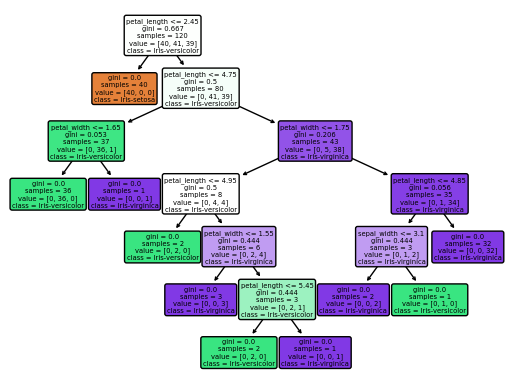

In [196]:
tree.plot_tree(DT,
               feature_names=X_train.columns,
               class_names=df_iris['species'].unique(),
               filled=True,
               rounded=True)

plt.show()

#### Titanic Dataset

Para ver casos más complejos, veamos otro dataset.

[dataset titanic](https://www.kaggle.com/datasets/heptapod/titanic)

Dedicado a información sobre los pasajeros del titanic, como su edad, sexo, clase, etc. Y si sobrevivieron o no.

In [ ]:
df_titanic = pd.read_excel('Titanic_dataset.xlsx')
df_titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [198]:
df_titanic['survived'].value_counts(dropna=False)

survived
0    809
1    500
Name: count, dtype: int64

Suponemos que 1 equivale a superviviente y 0 a no superviviente

Limpiamos los datos que no creemos que sean útiles Y transformamos los datos de tipo string en numéricos

In [199]:
df_titanic_clean = df_titanic.drop(columns=['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'])
df_titanic_clean['sex'] = pd.factorize(df_titanic_clean['sex'])[0]
df_titanic_clean['embarked'] = pd.factorize(df_titanic_clean['embarked'])[0]
df_titanic_clean.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,0
1,1,1,1,0.9167,1,2,151.5500,0
2,1,0,0,2.0000,1,2,151.5500,0
3,1,0,1,30.0000,1,2,151.5500,0
4,1,0,0,25.0000,1,2,151.5500,0


In [200]:
for column in df_titanic_clean.columns:
    print(column, df_titanic_clean[column].isnull().sum()*100/len(df_titanic_clean))

pclass 0.0
survived 0.0
sex 0.0
age 20.091673032849503
sibsp 0.0
parch 0.0
fare 0.07639419404125286
embarked 0.0


In [201]:
df_titanic_clean['age'] = df_titanic_clean['age'].fillna(df_titanic_clean['age'].mean())
df_titanic_clean['fare'] = df_titanic_clean['fare'].fillna(df_titanic_clean['fare'].mean())

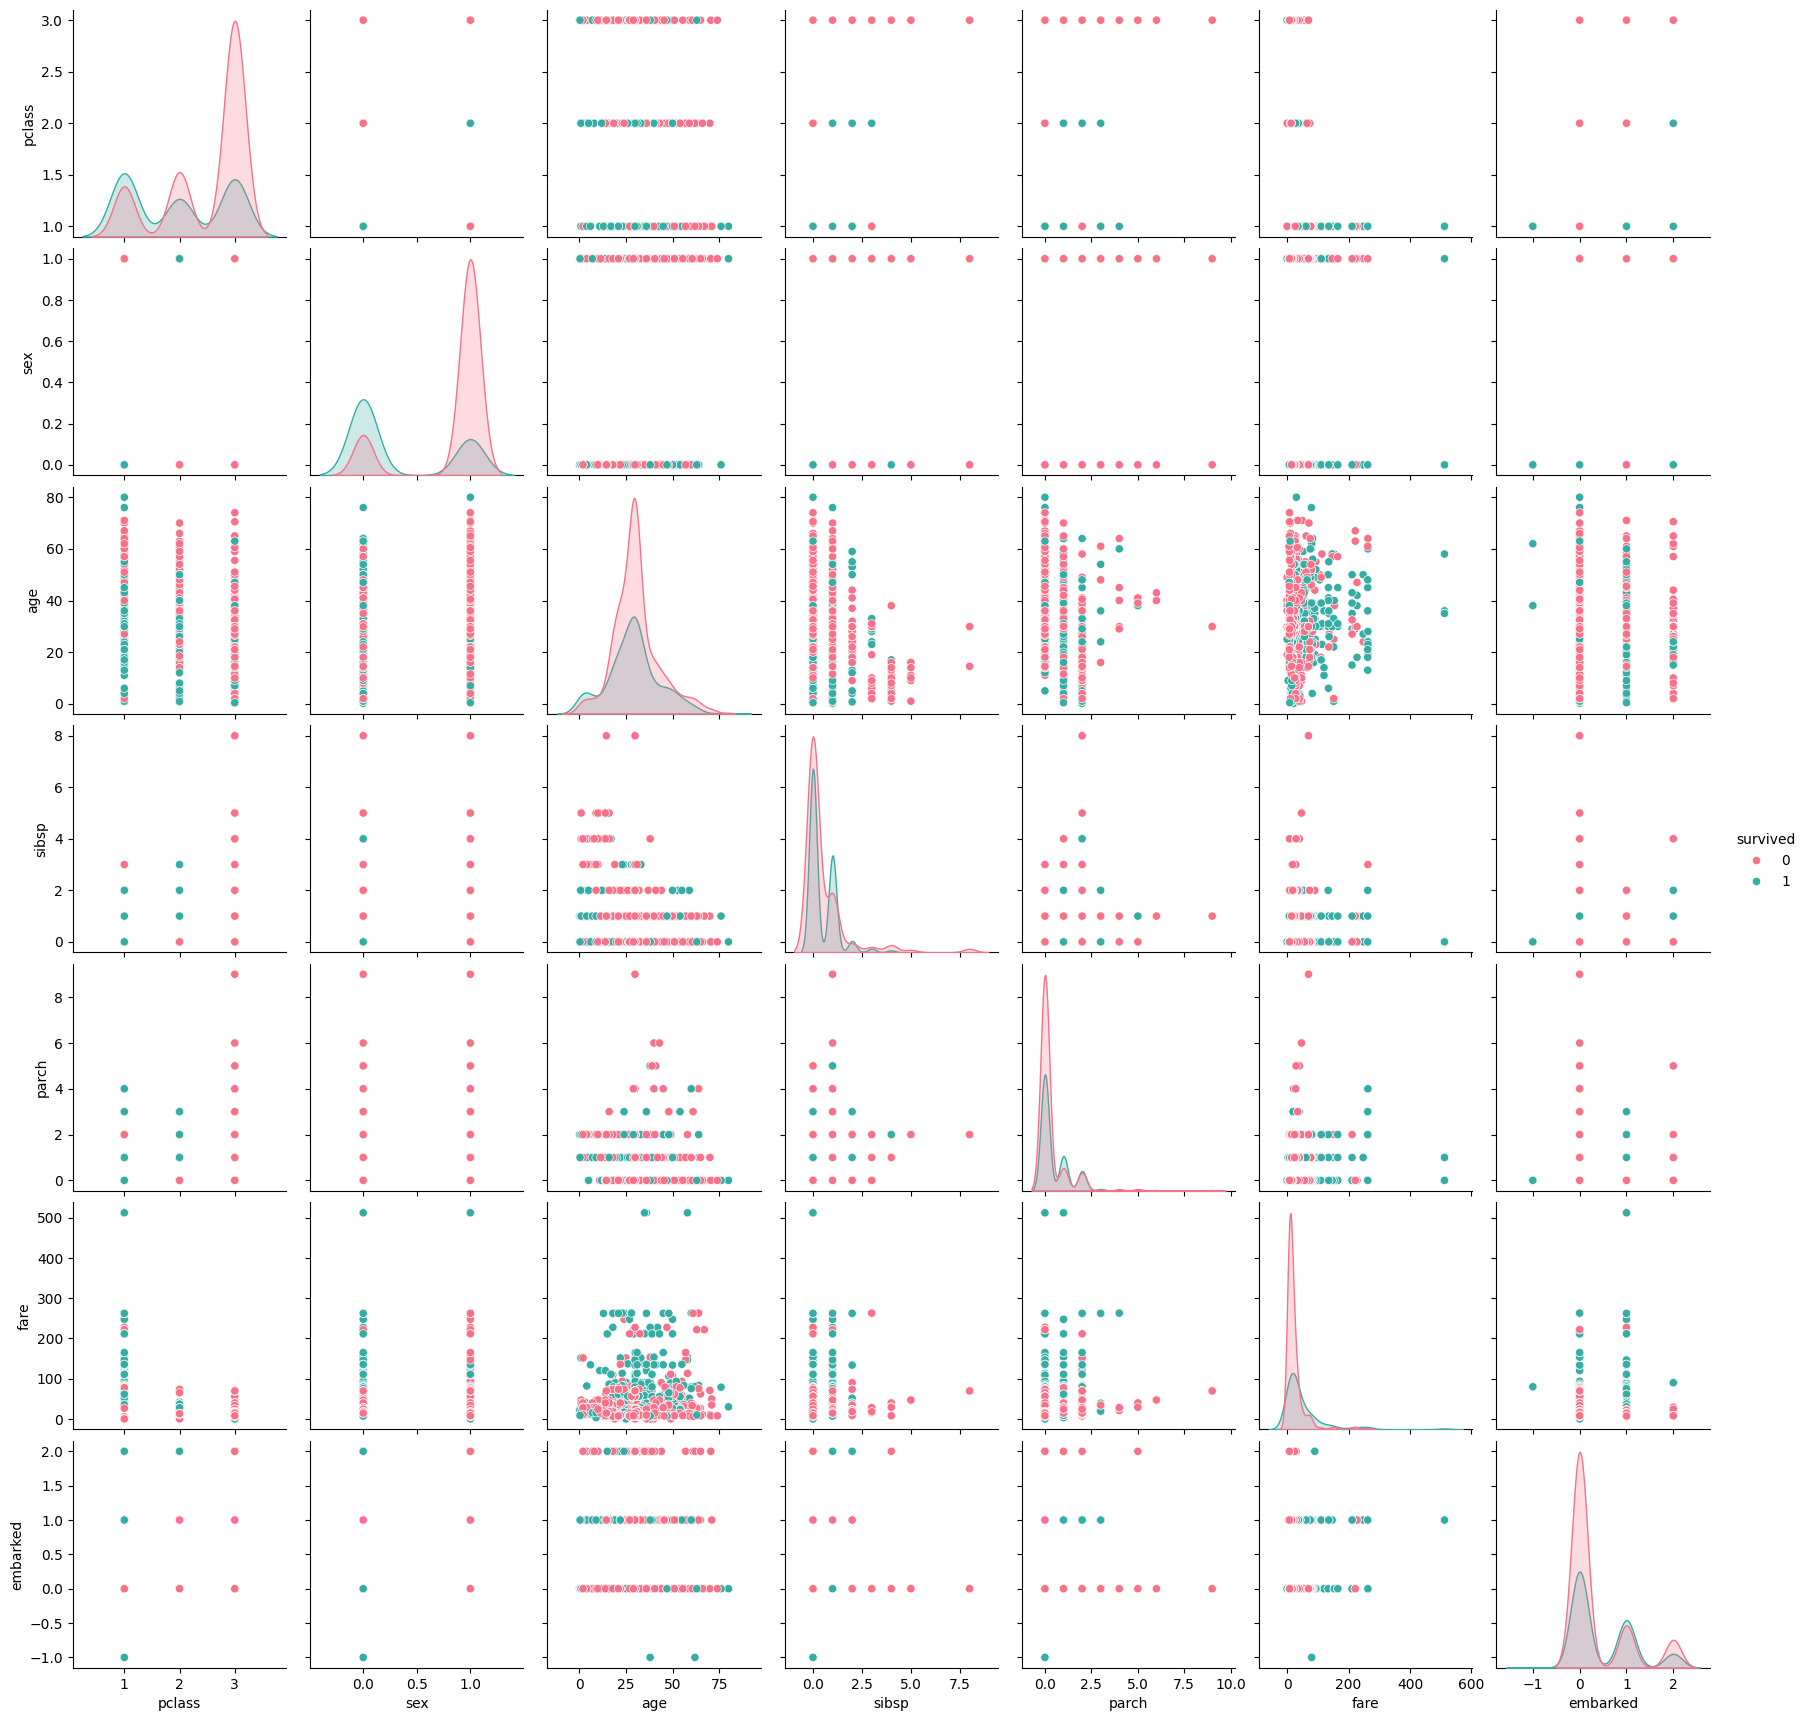

In [202]:
sns.pairplot(df_titanic_clean, hue='survived', palette='husl')

plt.show()


Dividimos los datos en entrenamiento y test

In [203]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic_clean.drop(columns=['survived']),
    df_titanic_clean['survived'], 
    test_size=0.2, 
    random_state=rn_state)

In [204]:
DT = tree.DecisionTreeClassifier(random_state=rn_state)
DT = DT.fit(X_train, y_train)
y_predicted = DT.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       144
           1       0.81      0.71      0.76       118

    accuracy                           0.79       262
   macro avg       0.80      0.79      0.79       262
weighted avg       0.80      0.79      0.79       262



Ahora sí vemos que nuestro accuracy no es perfecto, pero no sabemos en qué fallamos. Para ello podemos usar las otras métricas que hemos visto

Otra forma de visualizarlo es con una matriz de confusión

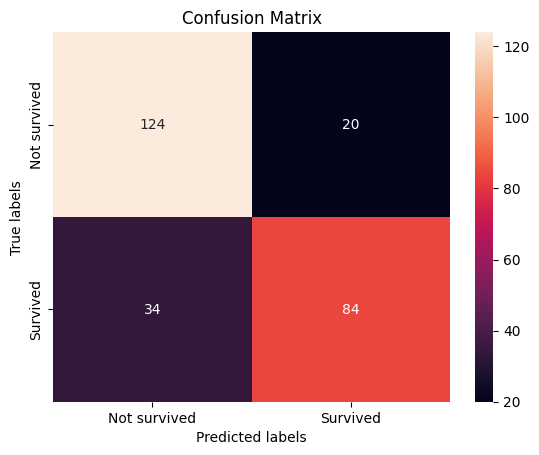

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ax= plt.subplot()
cm = confusion_matrix(y_test, y_predicted, labels=DT.classes_)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not survived', 'Survived']); ax.yaxis.set_ticklabels(['Not survived', 'Survived']);

De aquí vemos que cuando hay superviviente (True label 1) hay casi un 50% posibilidades de que lo detectemos.
Pero cuando el modelo da una respuesta, tenemos una posibilidad grande de haber acertado.

Predicted label 0: 78%

Predicted label 1: 81%

Esto se debe a la desproporción superviviente/no superviviente

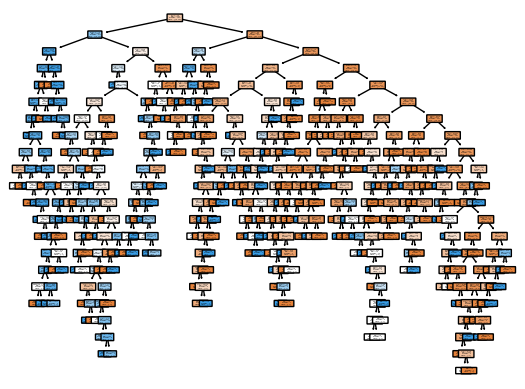

In [206]:
tree.plot_tree(DT,
               feature_names=X_train.columns,
               class_names=['Not survived', 'Survived'],
               filled=True,
               rounded=True)
plt.show()
# avoid the tree to plot the numrical value


Decision trees nos dan muchas posibilidades de mejorar sus resultados, trabajando con sus hiperparámetros

In [207]:
# Aumenta el número de muestras mínimas para continuar un nodo
DT = tree.DecisionTreeClassifier(random_state=rn_state, min_samples_leaf=10)
DT = DT.fit(X_train, y_train)
y_predicted = DT.predict(X_test)
print(classification_report(y_test, y_predicted))
# print('test accuracy: %.2f' % DT.score(X_test, y_test))
# print('test precision: %.2f' % precision_score(y_test, y_predicted))
# print('test recall: %.2f' % recall_score(y_test, y_predicted))
# print('test f1: %.2f' % f1_score(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       144
           1       0.85      0.59      0.70       118

    accuracy                           0.77       262
   macro avg       0.79      0.75      0.76       262
weighted avg       0.79      0.77      0.76       262



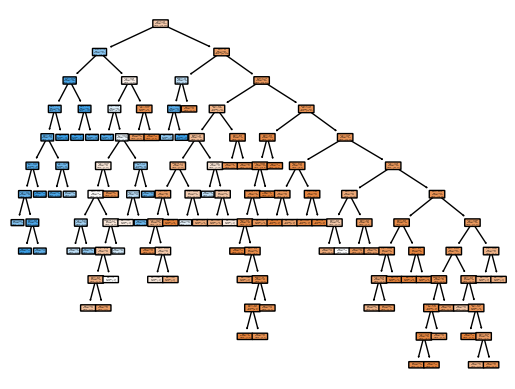

In [208]:
tree.plot_tree(DT,
               feature_names=X_train.columns,
               class_names=['Not survived', 'Survived'],
               filled=True,
               rounded=True)

plt.show()

O limitando su profundidad

In [209]:
DT = tree.DecisionTreeClassifier(random_state=rn_state, max_depth=3)
DT = DT.fit(X_train, y_train)
y_predicted = DT.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       144
           1       0.81      0.67      0.73       118

    accuracy                           0.78       262
   macro avg       0.78      0.77      0.77       262
weighted avg       0.78      0.78      0.78       262



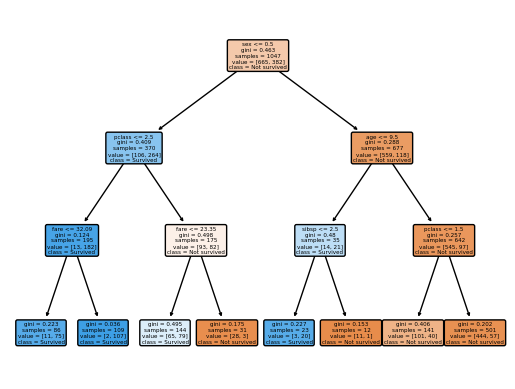

In [ ]:
tree.plot_tree(DT,
               feature_names=X_train.columns,
               class_names=['Not survived', 'Survived'],
               filled=True,
               rounded=True)

plt.show()

### Random Forest

In [211]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=rn_state)
random_forest = random_forest.fit(X_train, y_train)

y_predicted = random_forest.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       144
           1       0.81      0.70      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262



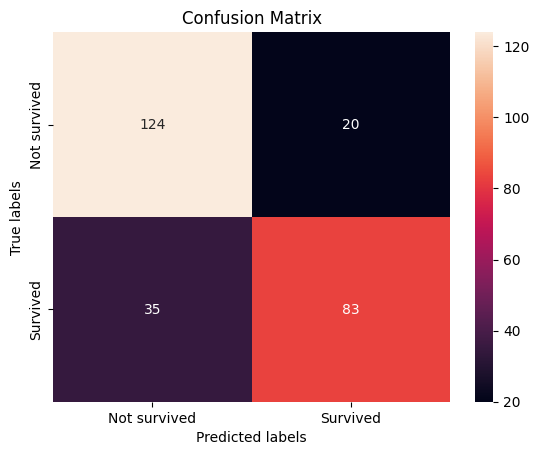

In [212]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ax= plt.subplot()
cm = confusion_matrix(y_test, y_predicted, labels=random_forest.classes_)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not survived', 'Survived']); ax.yaxis.set_ticklabels(['Not survived', 'Survived']);

Y podemos observar cada árbol y ver como cada uno empieza a especializarse en un tipo de dato

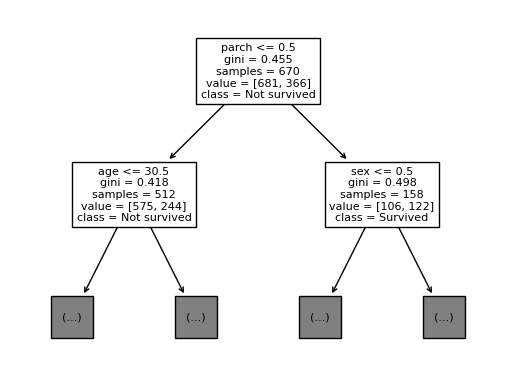

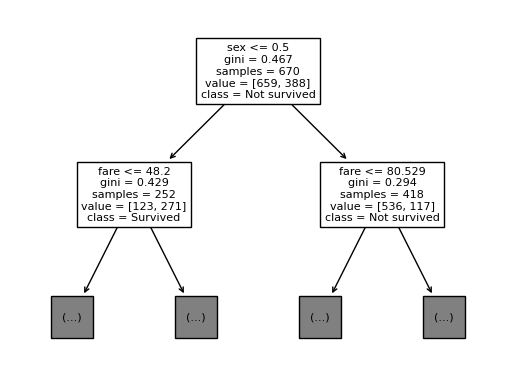

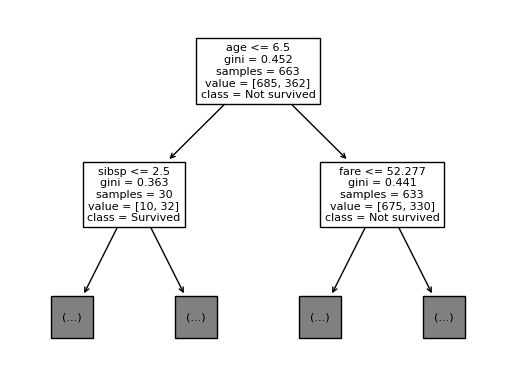

In [213]:
for decision_tree in random_forest.estimators_[:3]:
    tree.plot_tree(decision_tree,
                    feature_names=X_train.columns,
                    class_names=['Not survived', 'Survived'],
                    max_depth=1)
    plt.show()

Esto es el efecto de bootstrap

## SVM

Dejando atrás a los modelos de ensemble, podemos pasar a los support vector machine. Que una vez más se cargan y entrenan de forma similar

In [214]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df_iris.drop(columns=['species']), 
#     df_iris['species'], 
#     test_size=0.2, 
#     random_state=rn_state)

In [ ]:
from sklearn.svm import SVC
svc = SVC(random_state=rn_state, kernel='linear')
svc = svc.fit(X_train, y_train)

y_predicted = svc.predict(X_test)

print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.78      0.64      0.70       118

    accuracy                           0.76       262
   macro avg       0.76      0.74      0.75       262
weighted avg       0.76      0.76      0.75       262



Podemos ver un mapa de svc, pero necesitamos usar sólo dos dimensiones

In [216]:
df_titanic_clean

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.000000,0,0,211.3375,0
1,1,1,1,0.916700,1,2,151.5500,0
2,1,0,0,2.000000,1,2,151.5500,0
3,1,0,1,30.000000,1,2,151.5500,0
4,1,0,0,25.000000,1,2,151.5500,0
...,...,...,...,...,...,...,...,...
1304,3,0,0,14.500000,1,0,14.4542,1
1305,3,0,0,29.881135,1,0,14.4542,1
1306,3,0,1,26.500000,0,0,7.2250,1
1307,3,0,1,27.000000,0,0,7.2250,1


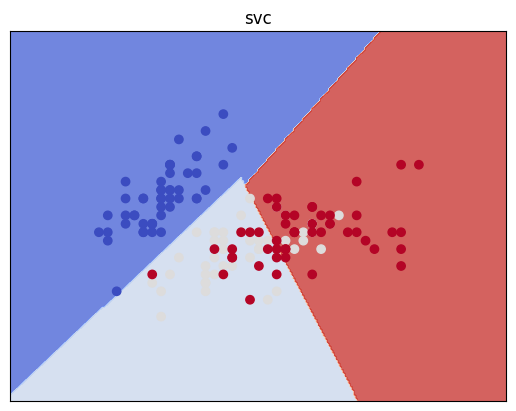

In [217]:
df_iris = pd.read_csv('IRIS.csv')
X = np.array(df_iris)[:, :2]  # we only take the first two features. We could
                    # avoid this ugly slicing by using a two-dim dataset
y = np.array(pd.factorize(df_iris['species'])[0])
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

# title for the plots
titles = 'SVC'
svc = SVC(random_state=rn_state, kernel='linear')
svc = svc.fit(X, y)

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("svc")

plt.show()

Podemos ver la dificultad de separar estos datos a base de un hiperplano.

## kNN

In [218]:
# Use knn to clasify the values
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       144
           1       0.65      0.48      0.55       118

    accuracy                           0.65       262
   macro avg       0.65      0.63      0.63       262
weighted avg       0.65      0.65      0.64       262



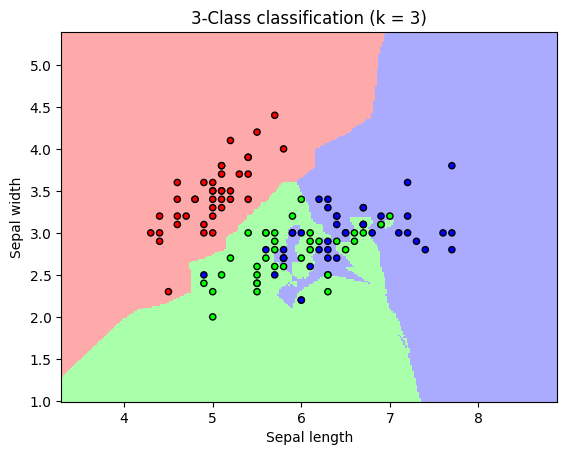

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Load iris dataset
iris = load_iris()
X = iris.data[:, :2]  # we only take the first two features for visualization
y = iris.target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create kNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Plot decision boundaries
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('3-Class classification (k = 3)')
plt.show()


# Conclusiones

En esta sección, hemos estudiado: 

- Los dos tipos de aprendizaje supervisado: regresión y clasificación

- Dentro de clasificación hemos visto modelos de tipo árbol, ensemble, SVM

- Dentro de regresión hemos visto regresión lineal y LASSO.
  
- Hemos visto cómo evaluar los modelos y cómo compararlos. 

- Se han visto diferentes técnicas de procesadode datos para su adecuación a casos concretos.

De aquí en adelante, podremos resolver cualquier problema que correspondan a datos tabulados, ya sea para poder generar un modelo productivo como un análisis detallado de los datos. 

In [ ]:
df_cardiovascular = pd.read_csv('Cardiovascular_Disease_Dataset.csv')
df_cardiovascular.head()



(1000, 14)